<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/LTSF_Linear_Data_%EC%8A%AC%EB%9D%BC%EC%9D%B4%EB%94%A9%EC%9C%88%EB%8F%84%EC%9A%B0%EC%A0%81%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
1. 구글드라이브 연결 및 데이터 로드
2. 식별 Column 정의
3. 학습에 사용할 센서 데이터 (수치) 분리
"""


from google.colab import drive
import os


drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d

# Machine Data 로드
file_path = "/content/drive/MyDrive/2026Conv_FDC/MACHINE_Data.xlsx"

# 파일 로드
if os.path.exists(file_path):
    print(f"{file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        print("지원하지 않는 파일 형식입니다.")
else:
    raise FileNotFoundError(f"File not found: {file_path}")

print(f"Machine Data 로드 완료. Shape: {df.shape}")

# 식별 및 정답 Column
meta_cols = ['Wafer_ID', 'Time_Step', 'Label', 'Fault_Type', 'Time', 'Step Number']

# 학습에 사용할 센서 변수 선택 (숫자형 데이터만 선택)
sensor_cols = [c for c in df.columns if c not in meta_cols]
# 문자열 데이터 필터링 추가
sensor_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"선택된 센서 변수 ({len(sensor_cols)}개):")
print(sensor_cols)

# 1. 라벨 구성 확인
print(df['Label'].value_counts())

# 2. 실험 ID별 데이터 개수 확인
for eid in ['l29', 'l31', 'l33']:
    count = df['Wafer_ID'].str.contains(eid, case=False).sum()
    print(f"실험 {eid} 데이터 개수: {count}")

Mounted at /content/drive
/content/drive/MyDrive/2026Conv_FDC/MACHINE_Data.xlsx
Machine Data 로드 완료. Shape: (12829, 25)
선택된 센서 변수 (19개):
['BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A', 'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err', 'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err', 'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve']
Label
Normal    10770
Fault      2059
Name: count, dtype: int64
실험 l29 데이터 개수: 4399
실험 l31 데이터 개수: 4180
실험 l33 데이터 개수: 4250


In [2]:
"""
데이터 전처리
MinMax 스케일러 정규화
Sliding Window 기법 시퀀스 생성
"""

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. 전처리 함수 정의 (이 부분이 정의되어야 에러가 나지 않습니다)
def preprocess_sensor_data(raw_data, seq_len=100):
    """
    논문 방식 전처리:
    1. MinMaxScaler를 이용한 0~1 정규화
    2. Sliding Window를 통한 시각(Time-step) 데이터 생성
    """
    # 데이터가 비어있는지 확인
    if len(raw_data) == 0:
        return np.array([]), None

    # 정규화 (Min-Max Scaling)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(raw_data)

    # 시퀀스 생성 (Sliding Window)
    sequences = []
    for i in range(len(scaled_data) - seq_len + 1):
        sequences.append(scaled_data[i:i + seq_len])

    return np.array(sequences), scaler

# 1. 실험 ID 리스트 정의
experiments = ['l29', 'l31', 'l33']

# 2. 전처리 결과를 담을 딕셔너리 초기화
datasets = {}

# 3. 이제 루프를 시작합니다

for exp_id in experiments:
    # 1. 해당 실험 데이터 추출 (Wafer_ID 필터링)
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]

    if exp_df.empty:
        print(f"⚠️ [{exp_id}] 데이터가 비어있습니다. 건너뜁니다.")
        continue

    # 2. 라벨에 따른 데이터 분리 (문자열로 수정!)
    train_df = exp_df[exp_df['Label'] == 'Normal']
    test_fault_df = exp_df[exp_df['Label'] == 'Fault']

    # 디버깅용 출력 추가
    print(f"🔍 [{exp_id}] 필터링 결과: Normal={len(train_df)}개, Fault={len(test_fault_df)}개")

    # 데이터 개수 확인 (seq_len=100 기준)
    if len(train_df) < 100:
        print(f"⚠️ [{exp_id}] 정상 데이터 부족으로 전처리를 진행할 수 없습니다.")
        continue

    # 3. 센서 데이터 추출
    train_raw = train_df[sensor_cols].values
    test_fault_raw = test_fault_df[sensor_cols].values if not test_fault_df.empty else np.array([])

    # 4. 전처리 함수 적용 (정상 데이터 학습용)
    X_train, scaler = preprocess_sensor_data(train_raw, seq_len=100)

    # 5. 불량 데이터 처리 (테스트용)
    X_test_fault = []
    if len(test_fault_raw) >= 100:
        # 학습 시 사용한 scaler로 정규화
        scaled_fault = scaler.transform(test_fault_raw)
        # 슬라이딩 윈도우 생성
        for i in range(len(scaled_fault) - 100 + 1):
            X_test_fault.append(scaled_fault[i:i + 100])
        X_test_fault = np.array(X_test_fault)
    else:
        X_test_fault = np.array([])

    # 6. 결과 저장 (이후 루프에서 사용될 datasets 딕셔너리)
    datasets[exp_id] = {
        'train': X_train,
        'test_normal': X_train, # 논문 방식에 따라 테스트용 정상 데이터로 train 일부 사용 가능
        'test_fault': X_test_fault,
        'scaler': scaler
    }
    print(f"✅ [{exp_id}] 전처리 완료: Train {X_train.shape}, Fault {X_test_fault.shape}")

🔍 [l29] 필터링 결과: Normal=3486개, Fault=913개
✅ [l29] 전처리 완료: Train (3387, 100, 19), Fault (814, 100, 19)
🔍 [l31] 필터링 결과: Normal=3638개, Fault=542개
✅ [l31] 전처리 완료: Train (3539, 100, 19), Fault (443, 100, 19)
🔍 [l33] 필터링 결과: Normal=3646개, Fault=604개
✅ [l33] 전처리 완료: Train (3547, 100, 19), Fault (505, 100, 19)


In [3]:
"""
LTSF_Linear 정의
"""

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

#클래스 정의
class LTSF_Linear(nn.Module):
    def __init__(self, window_size, forecast_size, individual, feature_size):
        super(LTSF_Linear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.individual = individual
        self.feature_size = feature_size

        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.feature_size):
                self.Linear.append(nn.Linear(self.window_size, self.forecast_size))
        else:
            self.Linear = nn.Linear(self.window_size, self.forecast_size)

    def forward(self, x):
        # x: [Batch, Input_Step, Feature]
        if self.individual:
            # 출력을 담을 텐서 생성
            output = torch.zeros([x.size(0), self.forecast_size, x.size(2)], dtype=x.dtype).to(x.device)
            for i in range(self.feature_size):
                # 각 센서(Feature)별로 학습된 Linear 층 적용
                # x[:, :, i]는 [Batch, Input_Step] -> 결과는 [Batch, Forecast_Step]
                output[:, :, i] = self.Linear[i](x[:, :, i])
            return output  # 결과를 반환해야 합니다.
        else:
            # [Batch, Input_Step, Feature] -> [Batch, Feature, Input_Step] 차원 변경
            x = x.permute(0, 2, 1)
            # Linear 적용 후 다시 원래대로 변경
            x = self.Linear(x)
            x = x.permute(0, 2, 1)
            return x  # 'x = self'가 아니라 계산된 x를 반환해야 합니다.


In [8]:
"""
LTSF-DLinear (Trend와 Remainder 데이터의 Decomposition)
정의
"""
import torch
import torch.nn as nn

# 1. 시계열 분해를 위한 Moving Average 클래스
class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # x: [Batch, Input_Step, Feature]
        # padding을 주어 출력 길이를 입력과 맞춤 (양 끝값 복제)
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        back = x[:, -1:, :].repeat(1, self.kernel_size // 2, 1)
        x = torch.cat([front, x, back], dim=1)
        x = x.permute(0, 2, 1) # [Batch, Feature, Input_Step]
        x = self.avg(x)
        x = x.permute(0, 2, 1) # [Batch, Input_Step, Feature]
        return x

class series_decomp(nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x) # Trend 성분 추출
        res = x - moving_mean            # Remainder 성분 추출
        return res, moving_mean

# 2. LTSF-DLinear 클래스 정의
class LTSF_DLinear(nn.Module):
    def __init__(self, window_size, forecast_size, individual, feature_size, kernel_size=25):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.individual = individual
        self.feature_size = feature_size

        # 시계열 분해 모듈
        self.decomposition = series_decomp(kernel_size)

        if self.individual:
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Res = nn.ModuleList()
            for i in range(self.feature_size):
                self.Linear_Trend.append(nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Res.append(nn.Linear(self.window_size, self.forecast_size))
        else:
            self.Linear_Trend = nn.Linear(self.window_size, self.forecast_size)
            self.Linear_Res = nn.Linear(self.window_size, self.forecast_size)

    def forward(self, x):
        # x: [Batch, Input_Step, Feature]
        # 1. 분해: Remainder(res)와 Trend(trend)로 나눔
        res, trend = self.decomposition(x)

        # 2. 각 성분에 대해 Linear 적용
        if self.individual:
            res_output = torch.zeros([x.size(0), self.forecast_size, x.size(2)], dtype=x.dtype).to(x.device)
            trend_output = torch.zeros([x.size(0), self.forecast_size, x.size(2)], dtype=x.dtype).to(x.device)

            for i in range(self.feature_size):
                res_output[:, :, i] = self.Linear_Res[i](res[:, :, i])
                trend_output[:, :, i] = self.Linear_Trend[i](trend[:, :, i])
        else:
            # [Batch, Input_Step, Feature] -> [Batch, Feature, Input_Step]
            res = res.permute(0, 2, 1)
            trend = trend.permute(0, 2, 1)

            res_output = self.Linear_Res(res).permute(0, 2, 1)
            trend_output = self.Linear_Trend(trend).permute(0, 2, 1)

        # 3. 두 성분을 다시 합쳐서 최종 복원/예측값 생성
        return res_output + trend_output

In [12]:
"""
NLinear 모델 정의

Linear 모델에 Normalization 작업이 추가된 것
시퀀스의 가장 마지막 값 (Drift가 발생한 최종 값)을
전체 시퀀스에서 다 빼줌으로써 상대적인 변화량만 남기고
이것을 선형회귀 연산하는 것
"""

class LTSF_NLinear(nn.Module):
    def __init__(self, window_size, forecast_size, individual, feature_size):
        super(LTSF_NLinear, self).__init__()
        self.window_size = window_size
        self.forecast_size = forecast_size
        self.individual = individual
        self.feature_size = feature_size

        if self.individual:
            self.Linear = nn.ModuleList()
            for i in range(self.feature_size):
                self.Linear.append(nn.Linear(self.window_size, self.forecast_size))
        else:
            self.Linear = nn.Linear(self.window_size, self.forecast_size)

    def forward(self, x):
        # x: [Batch, Input_Step, Feature]

        # 1. 마지막 값을 기준으로 정규화 (Normalization)
        seq_last = x[:, -1:, :].detach() # 마지막 시점의 값 추출
        x = x - seq_last                 # 모든 시점에서 마지막 값을 뺌

        # 2. Linear 연산
        if self.individual:
            output = torch.zeros([x.size(0), self.forecast_size, x.size(2)], dtype=x.dtype).to(x.device)
            for i in range(self.feature_size):
                output[:, :, i] = self.Linear[i](x[:, :, i])
        else:
            x = x.permute(0, 2, 1)
            x = self.Linear(x)
            output = x.permute(0, 2, 1)

        # 3. 다시 마지막 값을 더해줌 (Denormalization)
        output = output + seq_last
        return output


🚀 [l29] 실험 모델 학습 시작
Epoch [50/100], Loss: 0.000011
Epoch [100/100], Loss: 0.000003
✅ [l29] 학습 완료 및 모델 저장 성공

🚀 [l31] 실험 모델 학습 시작
Epoch [50/100], Loss: 0.000008
Epoch [100/100], Loss: 0.000003
✅ [l31] 학습 완료 및 모델 저장 성공

🚀 [l33] 실험 모델 학습 시작
Epoch [50/100], Loss: 0.000010
Epoch [100/100], Loss: 0.000005
✅ [l33] 학습 완료 및 모델 저장 성공


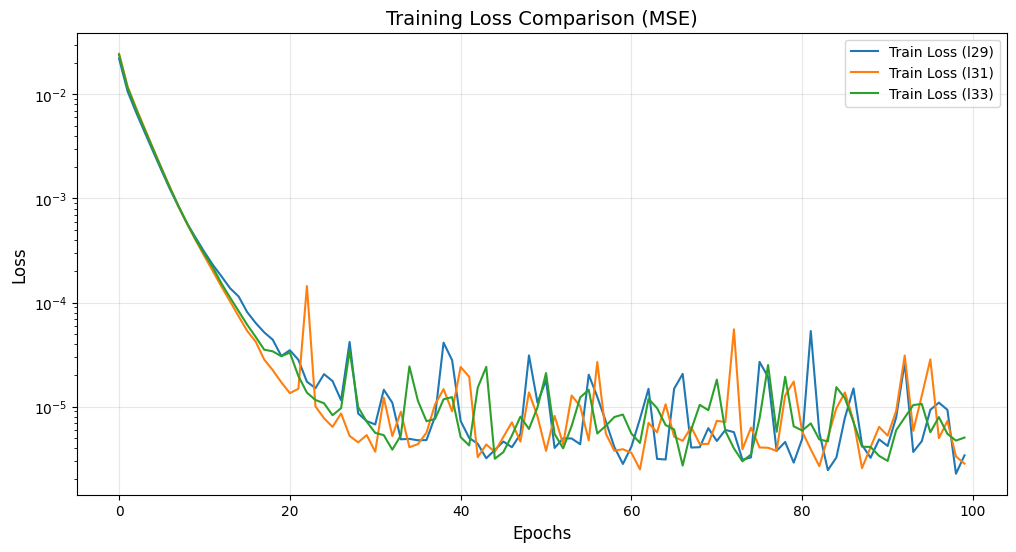

In [13]:
"""
Exp No.에 따라
각기 다른 가중치를 저장하도록
빈 딕셔너리를 선언 후 가중치 정보 저장

또한, 학습 모델을
Linear, DLinear, NLinear 세 가지로 구성이 되어있음
model = LTSF_Linear(...
부분에서 주석처리를 통해 원하는 모델을 선택
"""

# 1. 모델들을 저장할 빈 딕셔너리 생성
models = {}
train_histories = {}

for exp_id in experiments:
    print(f"\n🚀 [{exp_id}] 실험 모델 학습 시작")

    # 해당 실험 데이터 가져오기
    exp_data = datasets[exp_id]
    train_x = torch.tensor(exp_data['train'], dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(train_x), batch_size=16, shuffle=True)

    n_samples, seq_len, n_feats = train_x.shape

    # 2. 각 실험별로 독립적인 모델 객체 생성
    # 2.1. LTSF_Linear (주석 지우고, DLinear엔 주석 처리 후 사용)
    '''
    model = LTSF_Linear(
    window_size=seq_len,
    forecast_size=seq_len,
    individual=True,
    feature_size=n_feats
).to('cuda' if torch.cuda.is_available() else 'cpu') # GPU 사용 시 추가
    '''
    # 2.2. LTSF_DLinear
    '''
    model = LTSF_DLinear(
    window_size=seq_len,
    forecast_size=seq_len,   # 복원 모델이므로 window_size와 동일하게 설정
    individual=True,
    feature_size=n_feats,
    kernel_size=25           # 분해를 위한 커널 사이즈 추가 (기본값 25 권장)
).to('cuda' if torch.cuda.is_available() else 'cpu')
    '''

    #2.3. LTSF_NLinear
    model = LTSF_NLinear(
        window_size=seq_len,
        forecast_size=seq_len,
        individual=True,
        feature_size=n_feats
    ).to('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 3. 학습 루프
    epoch_losses = []
    model.train()
    for epoch in range(100):
        avg_loss = 0
        for batch in train_loader:
            inputs = batch[0].to(next(model.parameters()).device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        epoch_losses.append(avg_loss / len(train_loader))
        if (epoch+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/100], Loss: {epoch_losses[-1]:.6f}")

    # 4. 학습된 모델과 기록을 딕셔너리에 저장
    models[exp_id] = model
    train_histories[exp_id] = epoch_losses
    print(f"✅ [{exp_id}] 학습 완료 및 모델 저장 성공")

# 5. Training Loss 시각화
import matplotlib.pyplot as plt

# 시각화 설정
plt.figure(figsize=(12, 6))

# train_histories 딕셔너리에 저장된 데이터를 반복문으로 출력
for exp_id, losses in train_histories.items():
    plt.plot(losses, label=f'Train Loss ({exp_id})')

plt.title('Training Loss Comparison (MSE)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.yscale('log') # Loss 차이가 클 경우를 대비해 로그 스케일 권장
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [14]:
"""
데이터 시각화 코드
평가 코드 진행 전 선언
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

def plot_model_results(exp_id, title, y_true, y_pred, ai_scores, threshold):
    # 1. 지표 계산
    acc = accuracy_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, -ai_scores)
    except:
        auc = 0.0

    # 2. 시각화 레이아웃 설정 (1행 3열)
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    fig.suptitle(f"Experiment: {exp_id} ({title})", fontsize=16)

    # --- [A] AI Score Distribution (Timeline Scatter Plot) ---
    # 데이터 인덱스 생성
    indices = np.arange(len(ai_scores))
    y_true_arr = np.array(y_true)

    # 정상 데이터 플롯 (Healthy)
    axes[0].scatter(indices[y_true_arr == 1], ai_scores[y_true_arr == 1],
                    color='blue', label='Healthy', alpha=0.5, s=15, marker='o')
    # 불량 데이터 플롯 (Defective)
    axes[0].scatter(indices[y_true_arr == 0], ai_scores[y_true_arr == 0],
                    color='red', label='Defective', alpha=0.8, s=25, marker='x')

    # 임계치 라인 (Threshold)
    axes[0].axhline(threshold, color='black', linestyle='--', linewidth=2, label='Threshold')

    axes[0].set_title(f"[{title}] AI Score Distribution")
    axes[0].set_xlabel("Data Point Index")
    axes[0].set_ylabel("Anomaly Score (MSE)")
    axes[0].legend(loc='upper left')

    # --- [B] Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=['Pred Fault(0)', 'Pred Normal(1)'],
                yticklabels=['Actual Fault(0)', 'Actual Normal(1)'])
    axes[1].set_title(f"Confusion Matrix (Acc: {acc:.4f})")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    # --- [C] ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, -ai_scores)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_title("ROC Curve")
    axes[2].set_xlabel("False Positive Rate")
    axes[2].set_ylabel("True Positive Rate")
    axes[2].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return acc, auc

평가 시작: 웨이퍼 29, 31, 33에 대해 개별 가중치 적용


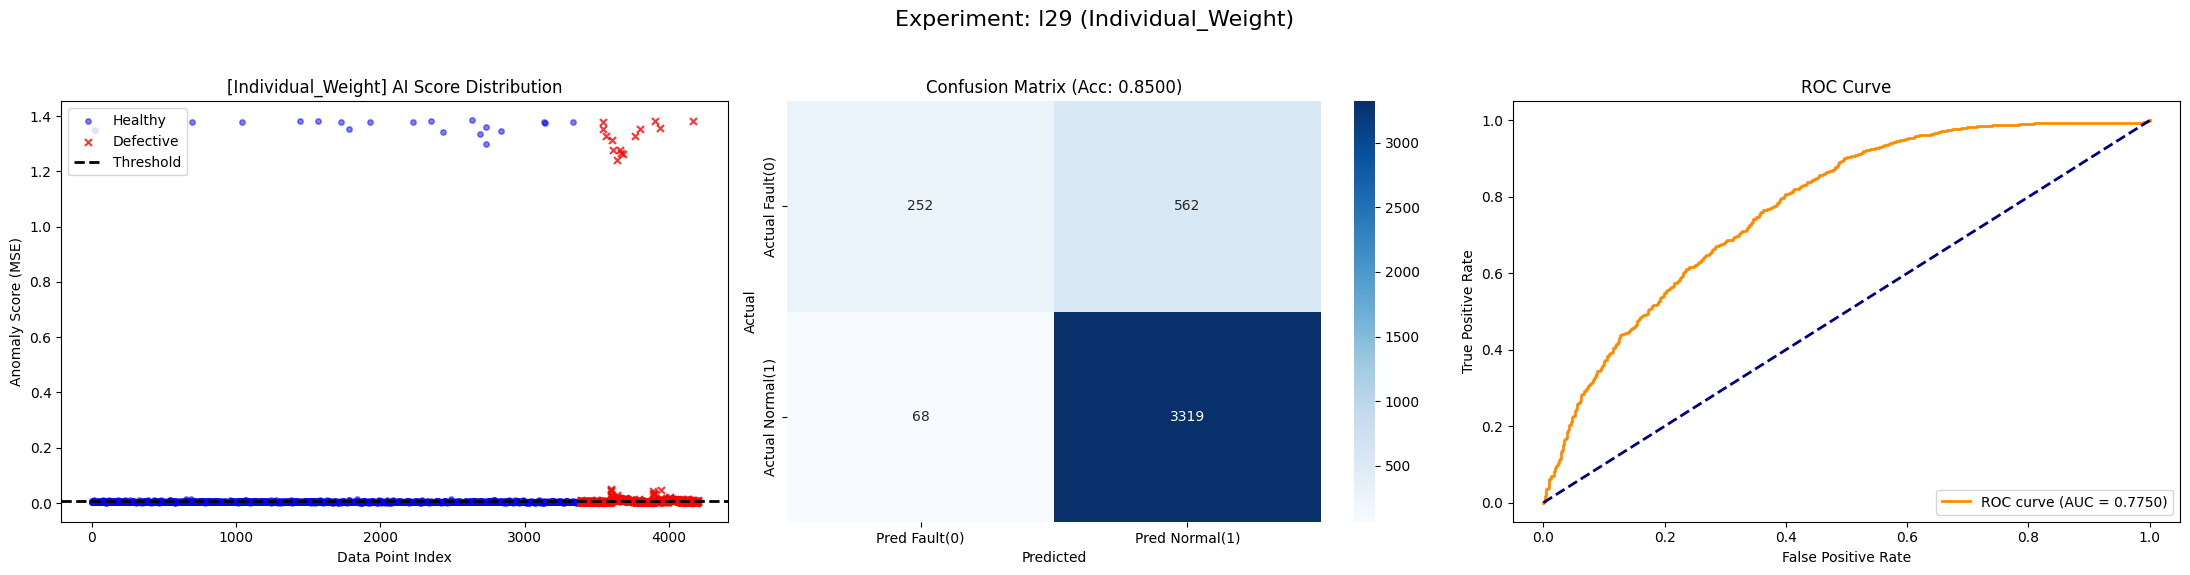

✅ [l29] 평가 완료: Acc=0.8500, AUC=0.7750


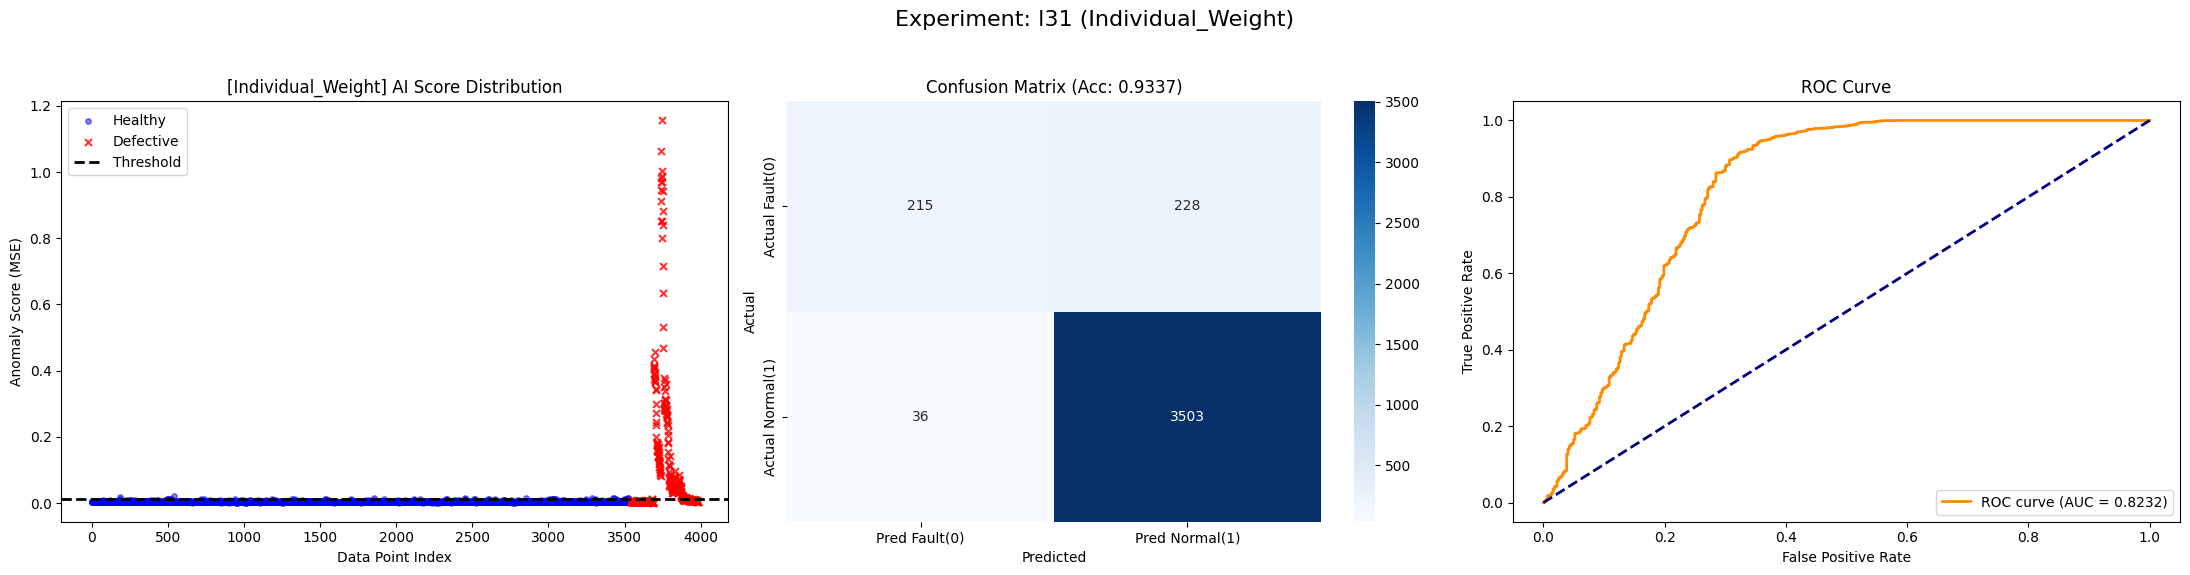

✅ [l31] 평가 완료: Acc=0.9337, AUC=0.8232


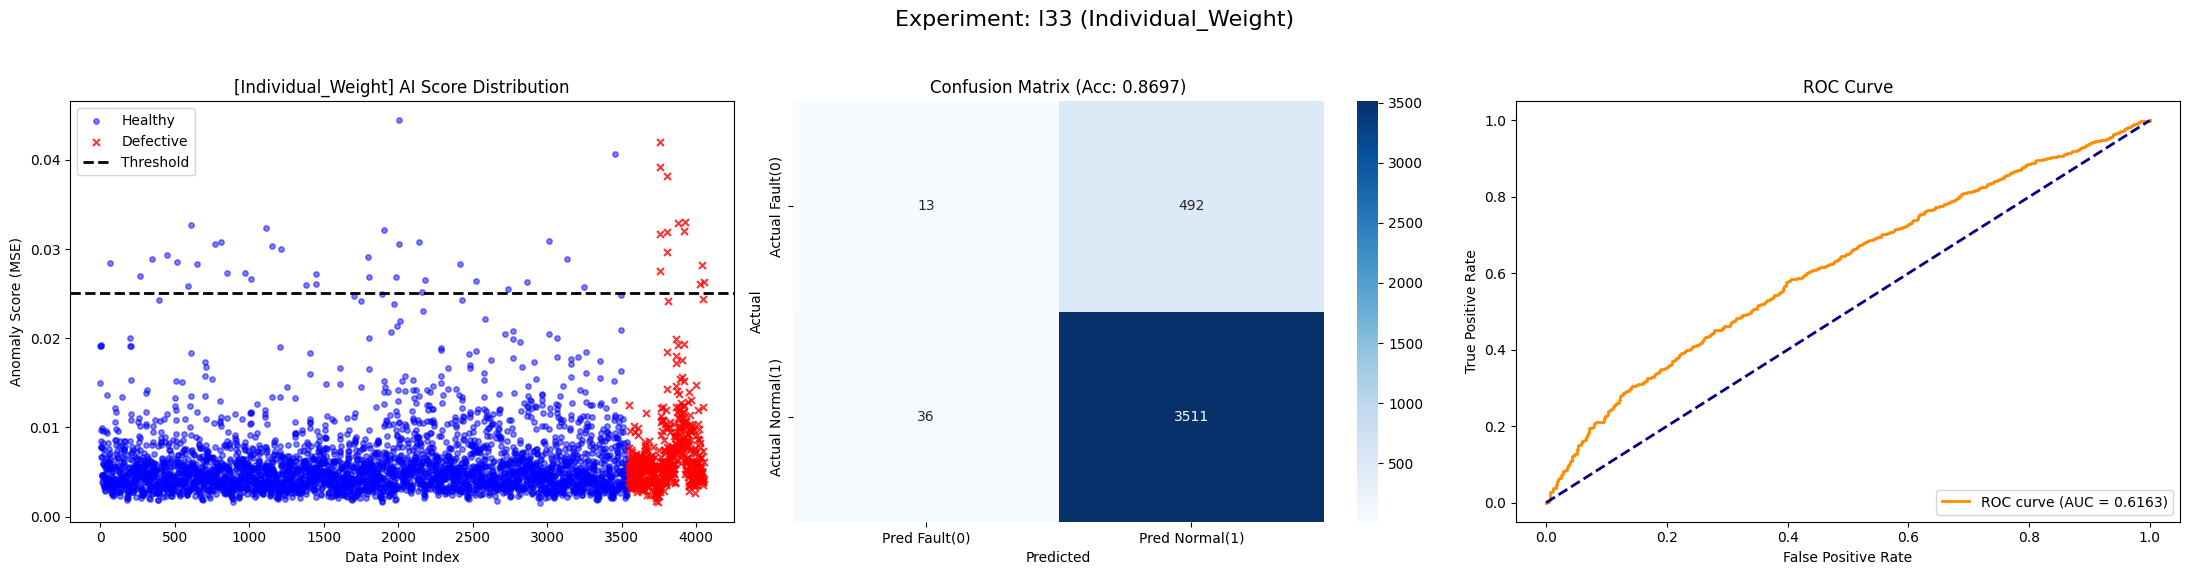

✅ [l33] 평가 완료: Acc=0.8697, AUC=0.6163

--- 최종 평가 결과 요약 ---
   Exp  Accuracy       AUC  Threshold  Train_Samples  Test_Samples
0  l29  0.850036  0.775026   0.008790           3387          4201
1  l31  0.933702  0.823209   0.011356           3539          3982
2  l33  0.869694  0.616250   0.025030           3547          4052


In [15]:
"""
LSTF-Linear, DLinear
Exp No. 29, 31, 33에 대응하는
Evaluation 및 데이터 시각화 수행
"""
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, roc_auc_score

# 1. 각 실험별 설정값 정의 (이 부분이 선언되어 있어야 합니다)
exp_configs = {
    'l29': {'clean_p': 98, 'thresh_p': 98, 'epochs': 100},
    'l31': {'clean_p': 99, 'thresh_p': 99, 'epochs': 100},
    'l33': {'clean_p': 99, 'thresh_p': 99, 'epochs': 100}
}

# 2. (선택사항) 만약 experiments 리스트가 정의되지 않았다면 추가
if 'experiments' not in locals():
    experiments = ['l29', 'l31', 'l33']

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 평가 결과 저장용
comparison_table = []

# 시각화 함수가 정의되어 있어야 합니다 (기존 plot_model_results 사용 가정)
# 만약 정의되지 않았다면 에러가 날 수 있으니 기존 코드를 참고하세요.

print(f"평가 시작: 웨이퍼 29, 31, 33에 대해 개별 가중치 적용")

for exp_id in experiments:
    # 1. 해당 실험의 설정 및 데이터/모델 불러오기
    conf = exp_configs[exp_id]
    model = models[exp_id] # 이전 단계에서 학습된 실험별 모델 (학습에 사용된게 Linear면 Linear를 추론에 사용, DLinear면 DLinear)
    exp_data = datasets[exp_id]

    X_train_raw = exp_data['train']
    X_test_normal = exp_data['test_normal']
    X_test_fault = exp_data['test_fault']

    # 2. 정답지(Label) 생성: Normal=1, Fault=0 (기존 코드 기준)
    y_true = [1] * len(X_test_normal) + [0] * len(X_test_fault)
    X_test_all = np.concatenate([X_test_normal, X_test_fault], axis=0)

    # 텐서 변환
    test_tensor = torch.FloatTensor(X_test_all).to(device)
    train_tensor = torch.FloatTensor(X_train_raw).to(device)

    # 3. 모델 평가 모드 전환 및 이상치 점수(AI) 계산
    model.eval()
    with torch.no_grad():
        # (A) 학습 데이터의 재구성 오차 계산 -> 임계치(Threshold) 설정용
        train_pred = model(train_tensor)
        # 차원 (샘플, 시점, 센서) 전체에 대해 MSE 계산 (sum of squares)
        tr_ai = torch.sum((train_tensor - train_pred)**2, dim=(1, 2)).cpu().numpy()

        # 설정된 퍼센타일(thresh_p)을 기준으로 임계치 결정
        thresh_val = np.percentile(tr_ai, conf['thresh_p'])

        # (B) 테스트 데이터의 재구성 오차 계산
        test_pred = model(test_tensor)
        ai_scores = torch.sum((test_tensor - test_pred)**2, dim=(1, 2)).cpu().numpy()

        # (C) 예측 수행: 점수가 임계치보다 작으면 정상(1), 크면 이상(0)
        y_pred = [1 if s <= thresh_val else 0 for s in ai_scores]

    # 4. 결과 시각화 및 성능 지표 계산
    # 기존에 사용하시던 plot_model_results 함수를 호출합니다.
    # 함수 내부에서 plt.show() 등이 실행되어 그래프가 출력됩니다.
    acc, auc = plot_model_results(exp_id, "Individual_Weight", y_true, y_pred, ai_scores, thresh_val)

    # 5. 비교 테이블 기록
    comparison_table.append({
        'Exp': exp_id,
        'Accuracy': acc,
        'AUC': auc,
        'Threshold': thresh_val,
        'Train_Samples': len(X_train_raw),
        'Test_Samples': len(X_test_all)
    })

    print(f"✅ [{exp_id}] 평가 완료: Acc={acc:.4f}, AUC={auc:.4f}")

# 최종 결과 요약 출력
import pandas as pd
df_results = pd.DataFrame(comparison_table)
print("\n--- 최종 평가 결과 요약 ---")
print(df_results)